### Note:

Add code to save graphs in showPlot function



In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re  
import random
import numpy as np
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import collections
from itertools import dropwhile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
PATH = "data/"


In [3]:
#!pip3 install sacrebleu
from sacrebleu import corpus_bleu


In [4]:
#read in chinese-english pairs
#read in chinese-english pairs
lines_zh = open(PATH+'iwslt-zh-en/train.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en = open(PATH+'iwslt-zh-en/train.tok.en',encoding = 'utf-8').read().strip().split('\n')
lines_zh_test = open(PATH+'iwslt-zh-en/test.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en_test = open(PATH+'iwslt-zh-en/test.tok.en',encoding = 'utf-8').read().strip().split('\n')
lines_zh_val = open(PATH+'iwslt-zh-en/dev.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en_val = open(PATH+'iwslt-zh-en/dev.tok.en',encoding = 'utf-8').read().strip().split('\n')

In [5]:
def delect_least_common_words(list_sent, threshold = 5):
    ret_list =[]
    for x in list_sent:
        ret_list += x.split()
    ret_dic = collections.Counter(ret_list)
    
    #print (ret_dic["&amp;"])
    #print (ret_dic["&apos;"])
    #print (ret_dic["&quot;"])
    #print (ret_dic["&#91"])
    for key, count in dropwhile(lambda key_count: key_count[1] >= threshold, ret_dic.most_common()):
        
        del ret_dic[key]
        
        
    return list(ret_dic.keys())

In [6]:
zh_words = delect_least_common_words(lines_zh)
en_words = delect_least_common_words(lines_en)

In [7]:
len(zh_words)

34443

In [8]:
words_to_load = 100000
PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

with open(PATH+'cc.zh.300.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+3, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.extend(['<pad>', '<unk>', '<s>'])
    loaded_embeddings_ft[0,:] = np.zeros(300)
    loaded_embeddings_ft[1,:] = np.random.normal(size = 300)
    loaded_embeddings_ft[2,:] = np.random.normal(size = 300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+3, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+3
        idx2words_ft[i+3] = s[0]
        ordered_words_ft.append(s[0])
    length = len(np.setdiff1d(zh_words, ordered_words_ft))
    tmp_embeddings = np.zeros((length, 300))
    for idx, word in enumerate(np.setdiff1d(zh_words, ordered_words_ft)):
        words_ft[word] = idx+words_to_load+3
        idx2words_ft[idx+words_to_load+3] = word
        tmp_embeddings[idx, :] = np.random.normal(size = 300)
    loaded_embeddings_ft = np.concatenate((loaded_embeddings_ft, tmp_embeddings), axis = 0)
    words_ft['<pad>'] = PAD_IDX
    words_ft['<unk>'] = UNK_IDX
    words_ft['<s>'] = SOS_IDX
    idx2words_ft[PAD_IDX] = '<pad>'
    idx2words_ft[UNK_IDX] = '<unk>'
    idx2words_ft[SOS_IDX] = '<s>'
    
ordered_words_ft = list(words_ft.keys())

In [9]:
#English embedding
with open(PATH+'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft_en = np.zeros((words_to_load+4, 300))
    words_ft_en = {}
    idx2words_ft_en = {}
    ordered_words_ft_en = []
    ordered_words_ft_en.extend(['<pad>', '<unk>', '<s>', '</s>'])
    loaded_embeddings_ft_en[0,:] = np.zeros(300)
    loaded_embeddings_ft_en[1,:] = np.random.normal(size = 300)
    loaded_embeddings_ft_en[2,:] = np.random.normal(size = 300)
    loaded_embeddings_ft_en[3,:] = np.random.normal(size = 300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft_en[i+4, :] = np.asarray(s[1:])
        words_ft_en[s[0]] = i+4
        idx2words_ft_en[i+4] = s[0]
        ordered_words_ft_en.append(s[0])
    length = len(np.setdiff1d(en_words, ordered_words_ft_en))
    tmp_embeddings = np.zeros((length, 300))
    for idx, word in enumerate(np.setdiff1d(en_words, ordered_words_ft_en)):
        words_ft_en[word] = idx+words_to_load+4
        idx2words_ft_en[idx+words_to_load+4] = word
        tmp_embeddings[idx, :] = np.random.normal(size = 300)
    loaded_embeddings_ft_en = np.concatenate((loaded_embeddings_ft_en, tmp_embeddings), axis = 0)
    words_ft_en['<pad>'] = PAD_IDX
    words_ft_en['<unk>'] = UNK_IDX
    words_ft_en['<s>'] = SOS_IDX
    words_ft_en['</s>'] = EOS_IDX
    idx2words_ft_en[PAD_IDX] = '<pad>'
    idx2words_ft_en[UNK_IDX] = '<unk>'
    idx2words_ft_en[SOS_IDX] = '<s>'
    idx2words_ft_en[EOS_IDX] = '</s>'
    
ordered_words_ft_en = list(words_ft_en.keys())

In [10]:
assert len(idx2words_ft) == len(words_ft)
assert len(loaded_embeddings_ft) == len(words_ft)
assert len(idx2words_ft_en) == len(words_ft_en)
assert len(loaded_embeddings_ft_en) == len(words_ft_en)
assert len(ordered_words_ft_en) == len(loaded_embeddings_ft_en)

In [11]:
#add sos and eos in each sentence
def add_sos_eos(lines):
    
    train = []
    for l in lines:
        l = '<s> ' + l + ' </s>'
        train.append(l)
    return train
zh_train = add_sos_eos(lines_zh)    
en_train = add_sos_eos(lines_en)
zh_test = add_sos_eos(lines_zh_test)
en_test = add_sos_eos(lines_en_test)
zh_val = add_sos_eos(lines_zh_val)
en_val = add_sos_eos(lines_en_val)

In [12]:
en_train[6]

'<s> And the problem , I think , is that we take the ocean for granted . </s>'

In [13]:
# convert token to id in the dataset
def token2index_dataset(tokens_data,eng = False):
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        for token in tokens.split():
            if eng == False:
                try:
                    index_list.append(words_ft[token])
                except KeyError:
                    index_list.append(UNK_IDX)
            else:
                try:
                    index_list.append(words_ft_en[token])
                except KeyError:
                    index_list.append(UNK_IDX)
        indices_data.append(index_list)
    return indices_data

In [14]:
zh_train_indices = token2index_dataset(zh_train)
en_train_indices = token2index_dataset(en_train,eng = True)
zh_val_indices = token2index_dataset(zh_val)
en_val_indices = token2index_dataset(en_val,eng = True)

In [15]:
#max_sentence_length
length_of_en = [len(x.split()) for x in en_train]
max_sentence_length_en = sorted(length_of_en)[-int(len(length_of_en)*0.01)]
length_of_zh = [len(x.split()) for x in zh_train]
max_sentence_length_zh = sorted(length_of_zh)[-int(len(length_of_zh)*0.01)]


In [16]:
max_sentence_length_en

74

In [17]:
#Create Data Loader
import torch
from torch.utils.data import Dataset

class load_dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_s1,data_list_s2):
        """
        @param data_list_zh: list of Chinese tokens 
        @param data_list_en: list of English tokens as TARGETS
        """
        self.data_list_s1 = data_list_s1
        self.data_list_s2 = data_list_s2
        
        assert (len(self.data_list_s1) == len(self.data_list_s2))

    def __len__(self):
        return len(self.data_list_s1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_s1 = self.data_list_s1[key][:max_sentence_length_zh]
        token_idx_s2 = self.data_list_s2[key][:max_sentence_length_en]
        return [token_idx_s1, token_idx_s2, len(token_idx_s1), len(token_idx_s2)]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_s1 = []
    data_list_s2 = []
    length_list_s1 = []
    length_list_s2 = []
    for datum in batch:
        length_list_s1.append(datum[2])
        length_list_s2.append(datum[3])
        padded_vec_zh = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sentence_length_zh-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec_en = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_sentence_length_en-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_zh[:max_sentence_length_zh])
        data_list_s2.append(padded_vec_en[:max_sentence_length_en])
    #print(type(data_list_s1[0]))
    
    return [torch.from_numpy(np.array(data_list_s1)).to(device), torch.from_numpy(np.array(data_list_s2)).to(device),
            torch.LongTensor(length_list_s1).to(device), torch.LongTensor(length_list_s2).to(device)]
    

In [18]:
BATCH_SIZE = 100
EMBEDDING_SIZE = 300 # fixed as from the input embedding data

train_dataset = load_dataset(zh_train_indices, en_train_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

val_dataset = load_dataset(zh_val_indices, en_val_indices)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

### With Attention

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hidden_size, embed= torch.from_numpy(loaded_embeddings_ft).float(),num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb_dim = emb_dim
        self.num_layers = num_layers 

        self.embedding = nn.Embedding.from_pretrained(embed, freeze=False)
        #self.gru = nn.GRU(emb_dim, hidden_size,num_layers=num_layers,batch_first=True,bidirectional = True)
        self.rnn = nn.LSTM(self.emb_dim, self.hidden_size, batch_first=True,
                           num_layers=self.num_layers, bidirectional=True)

    def forward(self, data, hidden):
        #hidden is a tuple (h,c)
        #dimension of h: num_layers * num_directions, batch, hidden_size 
        
        batch_size, seq_len = data.size()
        
        embed = self.embedding(data)
        
        
        #output, hidden = self.gru(embed,hidden)
        
        #hidden is a tuple (h,c). Dim of h: num_layers * num_directions, batch, hidden_size
        output, (h,c) = self.rnn(embed,hidden)
        
        h = torch.sum(h, dim=0).unsqueeze(0)
        c = torch.sum(c, dim=0).unsqueeze(0)
        
        hidden = (h,c)
        
        
        output = (output[:, :, :self.hidden_size] +
                output[:, :, self.hidden_size:])
        
        ## potentially there are other ways 
        
        
        #hidden = [n layers * n directions =1 , batch_size, hidden_size ]
        #print ("encoder hidden",hidden)
        #print ("encoder output", output.shape)

        return output, hidden

    # initialize the hidden with random numbers
    def initHidden(self,batch_size):
        return (torch.randn(2*self.num_layers, batch_size, self.hidden_size,device=device),
                torch.randn(2*self.num_layers, batch_size, self.hidden_size,device=device))
    

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self,emb_dim,hidden_size, output_size, embed= torch.from_numpy(loaded_embeddings_ft_en).float(),num_layers=1,
                 dropout_p=0.1, max_length=max_sentence_length_zh):
        super(AttnDecoderRNN, self).__init__()
       
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding.from_pretrained(embed, freeze=False)
        self.attn = nn.Linear(self.hidden_size + emb_dim, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + emb_dim, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        #self.gru = nn.GRU(hidden_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, bidirectional = False)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, data, hidden,encoder_outputs):
        
        ### embed: [1 * batch size * emb_dim = 300 ] ###
        ### hidden: [1 * batch size * hidden_size = 300 ] ###
        ### FOR LSTM, HIDDEN: tuple (h,c). h:(2, batch size, hidden_size)
        ### encoder_outputs: [batch size * max_sentence_length_zh * hidden_size = 300 ] ###
        ### 因为这里concat之后，attn layer 他给的是 hidden size *2 
        ### 所以我这儿的hidden size就只能写300了 
        
        embed = self.embedding(data)
        embed = self.dropout(embed)    
        ### torch.cat((embed, hidden), 2)  
        ### [1 * batch size * (emb_dim + hidden_size) ]
        
        ### attn_weights: [1 * batch size * max_sentence_length_zh ]###
        ### attn_weights[0].unsqueeze(1): [batch size * 1 * max_sentence_length_zh ]###
        
        ### softmax dim=2 因为最后一个dimension是 词组什么的，不能是1，1的话就是
        ### 不同batch间这样比较了？
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embed, hidden[0]), 2)), dim=2)
        

        ### torch.bmm(attn_weights[0].unsqueeze(1),encoder_outputs).squeeze(1) :
        ### [batch size * 1 * hidden_size ]###

        ### attn_applied: [batch size * hidden_size (= 300) ] ###
     
        attn_applied = torch.bmm(attn_weights[0].unsqueeze(1),
                                 encoder_outputs).squeeze(1)
        
        ### output: [batch size * hidden_size (= 300) ] ###
        ### embed[0]: [batch size * hidden_size (= 300) ] ###

        output = torch.cat((embed[0], attn_applied), 1)
 
        ### output: [1 * batch size * hidden_size (= 300) ] ###
        output = self.attn_combine(output).unsqueeze(0)
        
        ### output: [1 * batch size * hidden_size (= 300) ] ###
        output = F.relu(output)
        
        
        
        #output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)
        
        output = self.softmax(self.out(output[0]))
        
        return output, hidden, attn_weights

    def initHidden(self,batch_size):
        return torch.randn(self.num_layers, batch_size, self.hidden_size,device=device)

In [21]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, eee):
    
    ### target_tensor [batch size, max_sentence_length_en = 377] ###
    ### target_tensor [batch size, max_sentence_length_zh = 220] ###
    batch_size_1, input_length = input_tensor.size()
    batch_size_2, target_length = target_tensor.size()
    #print ("target length ", target_length)
    
    
    encoder_hidden = encoder.initHidden(batch_size_1)
    h,c = encoder_hidden
    #print ("encoder hidden init, ",h.shape)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    ### encoder_hidden: 1 * batch * hidden size ### 
    ### encoder_output: batch size * max_sentence_length_zh * hidden size ### 
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    #print ("encoder output, ", encoder_output.shape)

    decoder_input = torch.tensor(np.array([[SOS_IDX]]*batch_size_1).reshape(1,batch_size_1),device=device)
    decoder_hidden = encoder_hidden
    h1,c1 = encoder_hidden
    #print ("encoder hidden,", h1.shape)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    #print(use_teacher_forcing)
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            ### decoder_output: [batchsize,5000] ###
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_output)
            
            #print ("decoder output, ",decoder_output.shape)
            #print ("target_tensor, ",len(target_tensor[:,di]))
            loss += criterion(decoder_output, target_tensor[:,di])
            decoder_input = target_tensor[:,di].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_output)
                        
            ### decoder_output [batch size, 50003]  ###
            
            ### topi is a [batch size, 1] tensor first we remove the size 1
            ### demension then we add it at the beginning using squeeze
            ### 有点脑残诶，做个转置不就好了？
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            ### decoder_input [1, batch size]  ###
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, target_tensor[:,di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [22]:
from torch.optim.lr_scheduler import StepLR, LambdaLR
def trainIters(encoder, decoder, n_iters, folder,lr_decrease = False,print_every=1, plot_every=100, evaluate_every = 50,read_in_model = False,learning_rate=0.001,early_stop_tol = 10e-7):
    start = time.time()
    plot_losses = []
    plot_val = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    patience = 0
    
    early_stopped = False
    current_best_bleu = 0
    
    best_encoder = encoder.state_dict()
    best_decoder = decoder.state_dict()
    
    
    #--------------------------------------------	
    #	
    #    LOAD MODELS	
    #	
    #--------------------------------------------	
    	
        
    
    if not os.path.exists(folder):	
        os.makedirs(folder)	

    if read_in_model == True:
        if os.path.exists(folder+'/Encoder'):	
            print('---------------------------------------------------------------------')	
            print('----------------Readind trained model---------------------------------')	
            print('---------------------------------------------------------------------')	

            #read trained models	
            encoder.load_state_dict(torch.load(folder+"/Encoder"))
            decoder.load_state_dict(torch.load(folder+"/Decoder"))	

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    if lr_decrease == True:
        encoder_scheduler = StepLR(encoder_optimizer, step_size=1, gamma=0.4)
        decoder_scheduler = StepLR(decoder_optimizer, step_size=1, gamma=0.4)
    
    
    criterion = nn.CrossEntropyLoss()
    #criterion_val = nn.CrossEntropyLoss()
    
    last_val = 0
    for iter in range(1, n_iters + 1):
        if lr_decrease == True:
            encoder_scheduler.step()
            decoder_scheduler.step()
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(train_loader):
            input_tensor = data_s1
            target_tensor = data_s2
            #print("train",target_tensor.size())
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion,i)
            print_loss_total += loss
            plot_loss_total += loss

            if i % print_every == 0:
                if i != 0:
                    print_loss_avg = print_loss_total / print_every
                    print_loss_total = 0
                    print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                                 iter, iter / n_iters * 100, print_loss_avg))
                
            if i % plot_every == 0:
                if i != 0:
                    plot_loss_avg = plot_loss_total / plot_every
                    plot_losses.append(plot_loss_avg)
                    plot_loss_total = 0
                
            if i % evaluate_every == 0:
                if i != 0:
                    bleu_score,output_words,attentions = evaluate(val_loader, encoder, decoder)
                    if bleu_score > current_best_bleu:
                        current_best_bleu = bleu_score
                        
                        best_encoder = encoder.state_dict()
                        best_decoder = decoder.state_dict()
                        
                    plot_val.append(bleu_score)
                    #print ("BLEU: ",bleu_score)
                    
                    if bleu_score <= current_best_bleu:
                        patience += 1
                        
                    elif bleu_score > current_best_bleu and np.abs(bleu_score - current_best_bleu)/float(current_best_bleu) < early_stop_tol:
                        patience += 1
                    
                    else:
                        patience = 0
                        
                        
                    
                    
                    """
                    #If new bleu score is lower than last time
                    if bleu_score <= last_val:
                        patience += 1
                    #or does not improve by enough percentage
                    elif bleu_score > last_val and np.abs(bleu_score - last_val)/float(last_val) < early_stop_tol:
                        
                        patience += 1
                    #bleu score increased since last time
                    else:
                        #reset patience
                        patience = 0
                            
                    """    
                    if patience == 10:
                       
                        torch.save(best_encoder,folder +"/Encoder")
                        torch.save(best_decoder,folder +"/Decoder")
                        early_stopped = True
                        patience = 0
            
                        
                    last_val = bleu_score
                 
        if early_stopped == False:
        
            # Save the model for every epoch
            print('---------------------------------------------------------------------')	
            print('----------------Saving trained model---------------------------------')	
            print('---------------------------------------------------------------------')	

            torch.save(encoder.state_dict(),folder +"/Encoder")
            torch.save(decoder.state_dict(),folder +"/Decoder")

    showPlot(plot_losses,title = "Train Loss",name = "loss_"+folder)
    showPlot(plot_val, title = "BLEU Score on Validation Set",name = "bleu_"+folder)
    return plot_losses




In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points,title,name):
    plt.figure()
    
    plt.plot(points)
    plt.title(title)
    plt.savefig(name)
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [24]:
#loader can be test_loader or val_loader
def evaluate(loader, encoder, decoder, after_train_mode = False,beam = False, beam_k = 1):
    bleu_score_list = []
    big_pred_list = []
    big_ref_list = []
    with torch.no_grad():
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(loader):
            input_tensor = data_s1
            input_length = input_tensor.size()[0]
            #sentence_length to the output length
            sentence_length = data_s2.size()[1]
            encoder_hidden = encoder.initHidden(input_length)

            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            
            #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_input = torch.tensor(np.array([[SOS_IDX]]*input_length).reshape(1,input_length),device=device)

            decoder_hidden = encoder_hidden

            decoder_attentions = torch.zeros(sentence_length, sentence_length)
            decoded_words_eval = []
            sequences = [[list(), 1.0]]*input_length
            for di in range(sentence_length):
                decoded_words_sub = []
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_output)
                # decoder_attentions[di] = decoder_attention.data
                # topk(1) - softmax probability maximum
                if beam == True:
                    pass
#                     topv, topi = decoder_output.data.topk(beam_k)
#                     #batch loop
#                     C = []
#                     for idx, ind in enumerate(topi):
#                         H, _ = sequences[idx]
#                         for ele in ind:
#                             if ele.item() == EOS_IDX:
#                                 H.append('<EOS>')
#                             else:
#                                 H.append(idx2words_ft_en[ele.item()])
                         
                else:
                    topv, topi = decoder_output.data.topk(1) 
                    
                #batch loop
                
                
                for ind in topi:
                    
                    if ind.item() == EOS_IDX:
                        
                        decoded_words_sub.append(idx2words_ft_en[EOS_IDX])
                        
                    else:
                        decoded_words_sub.append(idx2words_ft_en[ind.item()])
                    
                
                decoded_words_eval.append(decoded_words_sub)
                
                #swap dimensions of decoded_words to [batch_size * 377]
                
                #decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]

                #change the dimension
                decoder_input = topi.squeeze().detach()
                decoder_input = decoder_input.unsqueeze(0)
            
            
            pred_num = 0
            listed_predictions = []
            
            
            decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]
            
            for token_list in decoded_words_new:
                sent = ' '.join(str(token) for token in token_list if token!="<pad>" and token!="<s>" and token!="</s>")
                #print (sent)
                listed_predictions.append(sent)
                #print (sent)
                pred_num += 1
                
            ref_num = 0
            listed_reference = []
            for ele in data_s2:
                sent = index2token_sentence(ele)
                #print (tokens)
                #sent = ' '.join(tokens)
                #print (sent)
                listed_reference.append(sent)
                ref_num += 1
            
            big_pred_list += listed_predictions
            big_ref_list += listed_reference
            
            assert len(big_pred_list) == len(big_ref_list)
            
            
            #uncommon to print prediction and reference
            #print (listed_predictions)
            #print (listed_reference)
        bleu_score = corpus_bleu(big_pred_list,[big_ref_list]).score
        
        if after_train_mode == True:
            for idx,ele in enumerate(big_pred_list):
                print (ele)
                print (big_ref_list[idx])
                print ("\n")
                
                
    print('BLEU Score is %s' % (str(bleu_score)))
        

    return bleu_score, decoded_words_new, decoder_attentions[:di + 1]
    
def index2token_batch(list_of_list):
    return ' '.join(idx2words_ft_en[r.item()] for v in list_of_list for r in v if r.item()!=PAD_IDX)
def index2token_sentence(sentence_batch):
    return ' '.join(idx2words_ft_en[sent.item()] for sent in sentence_batch if sent.item()!=PAD_IDX and sent.item()!=SOS_IDX and sent.item()!=EOS_IDX)

In [27]:
score_list, output_words, attentions = evaluate(val_loader, encoder1, decoder1,after_train_mode =True)

I was a little girl , I was a friend of mine , and I was a very long time .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was a <unk> , and he was a <unk> .
My father was listening to BBC News on his small , gray radio .


He was a very good job , but he was a very good , very good job .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The <unk> , the <unk> , the <unk> , &quot; <unk> &quot;
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what I &apos;m going to do , but I &apos;m going to be a little bit of what you &apos;re going to do .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can see that I &apos;m going to be a little bit of a child .
&quot; You can go to a real school now , &quot; he said .


I don &apos;t want to go to me .
A morning that I will never forget .


A lot of people have been doing th


I mean , I &apos;m going to say , &quot; I &apos;m going to be a problem . &quot;
Back to my question : Why did I stay ?


The answer is , &quot; What does it mean ? &quot;
The answer is easy .


I don &apos;t know what I &apos;m going to do .
I didn &apos;t know he was abusing me .


And he was a little bit of my house , and I was walking around the street , and I was in the middle of the <unk> , and I was in the middle of the room , and I was in the room , and I was in the morning , and I was in the middle of the room , and I &apos;m going to go to the first time ,
Even though he held those loaded guns to my head , pushed me down stairs , threatened to kill our dog , pulled the key out of the car ignition as I drove down the highway , poured coffee grinds on my head as I dressed for a job interview , I never once thought of myself as a battered wife .


I was in the middle of the United States , I was in the United States , I &apos;m a very good job , and I think , &quot; and the Am

0m 50s (- 3m 20s) (1 20%) 2.7630
1m 39s (- 6m 37s) (1 20%) 1.9663
2m 29s (- 9m 56s) (1 20%) 1.8638
3m 18s (- 13m 14s) (1 20%) 1.8324
4m 7s (- 16m 28s) (1 20%) 1.8316


BLEU Score is 2.944093962881793
5m 6s (- 20m 26s) (1 20%) 1.7771
5m 56s (- 23m 44s) (1 20%) 1.7542
6m 45s (- 27m 2s) (1 20%) 1.7451
7m 34s (- 30m 19s) (1 20%) 1.6990
8m 23s (- 33m 34s) (1 20%) 1.6587


BLEU Score is 3.6814378180946066
9m 22s (- 37m 29s) (1 20%) 1.6248
10m 11s (- 40m 47s) (1 20%) 1.6400
11m 1s (- 44m 5s) (1 20%) 1.5612
11m 49s (- 47m 19s) (1 20%) 1.5487
12m 39s (- 50m 37s) (1 20%) 1.5306


BLEU Score is 2.352095494703421
13m 38s (- 54m 32s) (1 20%) 1.5337
14m 27s (- 57m 50s) (1 20%) 1.4827
15m 16s (- 61m 7s) (1 20%) 1.4698
16m 6s (- 64m 24s) (1 20%) 1.4844
16m 55s (- 67m 42s) (1 20%) 1.4703


BLEU Score is 4.25118212648365
17m 54s (- 71m 36s) (1 20%) 1.4640
18m 43s (- 74m 54s) (1 20%) 1.4267
19m 32s (- 78m 8s) (1 20%) 1.4427
20m 21s (- 81m 26s) (1 20%) 1.4353
21m 11s (- 84m 44s) (1 20%) 1.4237


BLEU Score is 4.964846971539881
22m 9s (- 88m 38s) (1 20%) 1.3914
22m 58s (- 91m 54s) (1 20%) 1.4087
23m 47s (- 95m 8s) (1 20%) 1.4080
24m 36s (- 98m 25s) (1 20%) 1.3958
25m 25s (- 101m 43s) (1 20%) 1.3966


BLEU Score is 4.835353702721867
26m 24s (- 105m 38s) (1 20%) 1.3558
27m 13s (- 108m 55s) (1 20%) 1.3906
28m 2s (- 112m 9s) (1 20%) 1.3793
28m 50s (- 115m 23s) (1 20%) 1.3799
29m 40s (- 118m 40s) (1 20%) 1.3658


BLEU Score is 5.190844747324879
30m 40s (- 122m 40s) (1 20%) 1.3520
31m 29s (- 125m 58s) (1 20%) 1.3462
32m 18s (- 129m 15s) (1 20%) 1.3746
33m 7s (- 132m 28s) (1 20%) 1.3463
33m 55s (- 135m 43s) (1 20%) 1.3488


BLEU Score is 4.7631565705615575
34m 54s (- 139m 37s) (1 20%) 1.3421
35m 43s (- 142m 55s) (1 20%) 1.3438
---------------------------------------------------------------------
----------------Saving trained model---------------------------------
---------------------------------------------------------------------
37m 7s (- 55m 41s) (2 40%) 2.1906
37m 56s (- 56m 55s) (2 40%) 1.3033
38m 46s (- 58m 9s) (2 40%) 1.3073
39m 35s (- 59m 23s) (2 40%) 1.2706
40m 25s (- 60m 38s) (2 40%) 1.2726


BLEU Score is 4.829994781008016
41m 23s (- 62m 4s) (2 40%) 1.2874
42m 12s (- 63m 18s) (2 40%) 1.2693
43m 2s (- 64m 33s) (2 40%) 1.2762
43m 51s (- 65m 47s) (2 40%) 1.2633
44m 40s (- 67m 0s) (2 40%) 1.2720


BLEU Score is 4.7683209389558305
45m 39s (- 68m 29s) (2 40%) 1.2692
46m 29s (- 69m 43s) (2 40%) 1.2718
47m 18s (- 70m 58s) (2 40%) 1.2661
48m 8s (- 72m 12s) (2 40%) 1.2506
48m 56s (- 73m 25s) (2 40%) 1.2549


BLEU Score is 4.763967267478428
49m 55s (- 74m 52s) (2 40%) 1.2715
50m 44s (- 76m 6s) (2 40%) 1.2597
51m 33s (- 77m 20s) (2 40%) 1.2602
52m 22s (- 78m 33s) (2 40%) 1.2674
53m 10s (- 79m 45s) (2 40%) 1.2394


BLEU Score is 4.724399277955505
54m 7s (- 81m 11s) (2 40%) 1.2176
54m 55s (- 82m 23s) (2 40%) 1.2551
55m 44s (- 83m 36s) (2 40%) 1.2617
56m 32s (- 84m 49s) (2 40%) 1.2572
57m 21s (- 86m 1s) (2 40%) 1.2579


BLEU Score is 4.33540847764827
58m 18s (- 87m 27s) (2 40%) 1.2436
59m 6s (- 88m 39s) (2 40%) 1.2615
59m 54s (- 89m 52s) (2 40%) 1.2352
60m 43s (- 91m 4s) (2 40%) 1.2343
61m 31s (- 92m 17s) (2 40%) 1.2600


BLEU Score is 4.238642723598271
62m 28s (- 93m 43s) (2 40%) 1.2383
63m 17s (- 94m 56s) (2 40%) 1.2505
64m 5s (- 96m 8s) (2 40%) 1.2412
64m 54s (- 97m 21s) (2 40%) 1.2467
65m 42s (- 98m 34s) (2 40%) 1.2379


BLEU Score is 4.4978722802459465
66m 41s (- 100m 1s) (2 40%) 1.2319
67m 29s (- 101m 14s) (2 40%) 1.2196
68m 19s (- 102m 28s) (2 40%) 1.2344
69m 8s (- 103m 43s) (2 40%) 1.2420
69m 58s (- 104m 57s) (2 40%) 1.2418


BLEU Score is 4.7675381605486935
70m 56s (- 106m 24s) (2 40%) 1.2154
71m 45s (- 107m 37s) (2 40%) 1.2270
73m 8s (- 48m 45s) (3 60%) 1.9974
73m 57s (- 49m 18s) (3 60%) 1.1920
74m 46s (- 49m 51s) (3 60%) 1.1736
75m 35s (- 50m 23s) (3 60%) 1.1563
76m 25s (- 50m 56s) (3 60%) 1.1819


BLEU Score is 4.350273437166143
77m 23s (- 51m 35s) (3 60%) 1.1876
78m 13s (- 52m 8s) (3 60%) 1.1897
79m 1s (- 52m 41s) (3 60%) 1.1879
79m 50s (- 53m 13s) (3 60%) 1.2117
80m 40s (- 53m 46s) (3 60%) 1.1732


BLEU Score is 4.384272570675829
81m 38s (- 54m 25s) (3 60%) 1.1695
82m 28s (- 54m 59s) (3 60%) 1.1701
83m 17s (- 55m 31s) (3 60%) 1.1916
84m 6s (- 56m 4s) (3 60%) 1.1747
84m 56s (- 56m 37s) (3 60%) 1.1884


BLEU Score is 4.55304765502597
85m 54s (- 57m 16s) (3 60%) 1.1780
86m 43s (- 57m 48s) (3 60%) 1.1530
87m 32s (- 58m 21s) (3 60%) 1.1802
88m 22s (- 58m 54s) (3 60%) 1.1691
89m 11s (- 59m 27s) (3 60%) 1.1825


BLEU Score is 4.588201140302987
90m 11s (- 60m 7s) (3 60%) 1.1690
91m 0s (- 60m 40s) (3 60%) 1.1636
91m 49s (- 61m 13s) (3 60%) 1.1684
92m 39s (- 61m 46s) (3 60%) 1.1573
93m 28s (- 62m 19s) (3 60%) 1.1880


BLEU Score is 4.636725496413126
94m 26s (- 62m 57s) (3 60%) 1.1563
95m 15s (- 63m 30s) (3 60%) 1.1668
96m 5s (- 64m 3s) (3 60%) 1.1719
96m 54s (- 64m 36s) (3 60%) 1.1829
97m 44s (- 65m 9s) (3 60%) 1.1868


BLEU Score is 4.446913462343751
98m 41s (- 65m 47s) (3 60%) 1.1660
99m 31s (- 66m 20s) (3 60%) 1.1471
100m 20s (- 66m 53s) (3 60%) 1.1700
101m 10s (- 67m 26s) (3 60%) 1.1796
101m 59s (- 67m 59s) (3 60%) 1.1534


BLEU Score is 4.808832970589386
102m 57s (- 68m 38s) (3 60%) 1.1823
103m 46s (- 69m 11s) (3 60%) 1.1581
104m 36s (- 69m 44s) (3 60%) 1.1600
105m 26s (- 70m 17s) (3 60%) 1.1778
106m 14s (- 70m 49s) (3 60%) 1.1587


BLEU Score is 4.537442028027894
107m 12s (- 71m 28s) (3 60%) 1.1763
108m 1s (- 72m 1s) (3 60%) 1.1529
109m 25s (- 27m 21s) (4 80%) 1.9240
110m 13s (- 27m 33s) (4 80%) 1.1251
111m 2s (- 27m 45s) (4 80%) 1.1324
111m 51s (- 27m 57s) (4 80%) 1.1168
112m 41s (- 28m 10s) (4 80%) 1.1457


BLEU Score is 4.685509323198142
113m 39s (- 28m 24s) (4 80%) 1.1162
114m 29s (- 28m 37s) (4 80%) 1.1466
115m 17s (- 28m 49s) (4 80%) 1.1194
116m 6s (- 29m 1s) (4 80%) 1.1658
116m 55s (- 29m 13s) (4 80%) 1.1344


BLEU Score is 4.74659429968887
117m 55s (- 29m 28s) (4 80%) 1.1479
118m 44s (- 29m 41s) (4 80%) 1.1163
119m 33s (- 29m 53s) (4 80%) 1.1402
120m 22s (- 30m 5s) (4 80%) 1.1525
121m 12s (- 30m 18s) (4 80%) 1.1114


BLEU Score is 4.799714397409697
122m 11s (- 30m 32s) (4 80%) 1.1562
123m 0s (- 30m 45s) (4 80%) 1.1603
123m 49s (- 30m 57s) (4 80%) 1.1331
124m 38s (- 31m 9s) (4 80%) 1.1111
125m 28s (- 31m 22s) (4 80%) 1.1323


BLEU Score is 4.714330805952549
126m 28s (- 31m 37s) (4 80%) 1.1392
127m 17s (- 31m 49s) (4 80%) 1.1185
128m 6s (- 32m 1s) (4 80%) 1.1190
128m 55s (- 32m 13s) (4 80%) 1.1435
129m 44s (- 32m 26s) (4 80%) 1.1455


BLEU Score is 4.846392876399438
130m 43s (- 32m 40s) (4 80%) 1.1470
131m 31s (- 32m 52s) (4 80%) 1.1155
132m 21s (- 33m 5s) (4 80%) 1.1117
133m 10s (- 33m 17s) (4 80%) 1.1300
133m 59s (- 33m 29s) (4 80%) 1.1204


BLEU Score is 4.814306817424572
134m 58s (- 33m 44s) (4 80%) 1.1529
135m 46s (- 33m 56s) (4 80%) 1.1058
136m 35s (- 34m 8s) (4 80%) 1.1464
137m 23s (- 34m 20s) (4 80%) 1.1428
138m 11s (- 34m 32s) (4 80%) 1.1351


BLEU Score is 4.879871589941051
139m 8s (- 34m 47s) (4 80%) 1.1367
139m 57s (- 34m 59s) (4 80%) 1.1019
140m 45s (- 35m 11s) (4 80%) 1.1303
141m 34s (- 35m 23s) (4 80%) 1.1370
142m 22s (- 35m 35s) (4 80%) 1.1463


BLEU Score is 4.703025619009713
143m 19s (- 35m 49s) (4 80%) 1.1208
144m 7s (- 36m 1s) (4 80%) 1.1496
145m 29s (- 0m 0s) (5 100%) 1.8962
146m 17s (- 0m 0s) (5 100%) 1.1257
147m 6s (- 0m 0s) (5 100%) 1.1235
147m 54s (- 0m 0s) (5 100%) 1.1242
148m 42s (- 0m 0s) (5 100%) 1.1206


BLEU Score is 4.829757872447216
149m 40s (- 0m 0s) (5 100%) 1.1083
150m 30s (- 0m 0s) (5 100%) 1.1082
151m 19s (- 0m 0s) (5 100%) 1.1094
152m 9s (- 0m 0s) (5 100%) 1.1260
152m 57s (- 0m 0s) (5 100%) 1.0861


BLEU Score is 4.8868300348690035
153m 55s (- 0m 0s) (5 100%) 1.1237
154m 45s (- 0m 0s) (5 100%) 1.1098
155m 34s (- 0m 0s) (5 100%) 1.1257
156m 24s (- 0m 0s) (5 100%) 1.1389
157m 12s (- 0m 0s) (5 100%) 1.1016


BLEU Score is 4.895817531196776
158m 11s (- 0m 0s) (5 100%) 1.1233
159m 0s (- 0m 0s) (5 100%) 1.1058
159m 50s (- 0m 0s) (5 100%) 1.1204
160m 39s (- 0m 0s) (5 100%) 1.1083
161m 28s (- 0m 0s) (5 100%) 1.1240


BLEU Score is 4.979684501735286
162m 27s (- 0m 0s) (5 100%) 1.1260
163m 16s (- 0m 0s) (5 100%) 1.1067
164m 6s (- 0m 0s) (5 100%) 1.1187
164m 54s (- 0m 0s) (5 100%) 1.1065
165m 44s (- 0m 0s) (5 100%) 1.1194


BLEU Score is 4.9121760862955846
166m 43s (- 0m 0s) (5 100%) 1.0665
167m 33s (- 0m 0s) (5 100%) 1.1123
168m 22s (- 0m 0s) (5 100%) 1.1037
169m 11s (- 0m 0s) (5 100%) 1.1218
170m 0s (- 0m 0s) (5 100%) 1.1105


BLEU Score is 4.947223171398112
171m 0s (- 0m 0s) (5 100%) 1.1110
171m 50s (- 0m 0s) (5 100%) 1.0986
172m 38s (- 0m 0s) (5 100%) 1.1122
173m 28s (- 0m 0s) (5 100%) 1.1401
174m 17s (- 0m 0s) (5 100%) 1.1210


BLEU Score is 4.89738754958043
175m 17s (- 0m 0s) (5 100%) 1.1066
176m 6s (- 0m 0s) (5 100%) 1.1162
176m 55s (- 0m 0s) (5 100%) 1.1192
177m 45s (- 0m 0s) (5 100%) 1.1302
178m 34s (- 0m 0s) (5 100%) 1.1148


BLEU Score is 4.934375271856519
179m 34s (- 0m 0s) (5 100%) 1.1151
180m 22s (- 0m 0s) (5 100%) 1.0917


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

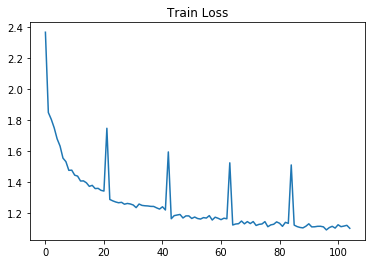

In [26]:
hidden_size = 300
encoder1 = EncoderRNN(EMBEDDING_SIZE,hidden_size).to(device)
decoder1 = AttnDecoderRNN(EMBEDDING_SIZE,hidden_size, len(ordered_words_ft_en)).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, decoder1, 5,'bilstm_att', lr_decrease = True,print_every=50,plot_every = 100, evaluate_every = 250,learning_rate=0.005)

In [37]:
# beam search + bleu score
def beam_search_decoder(data, k):
    sequences = [[list(), 1.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score * -log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select top best
        sequences = ordered[:1]
    return sequences

In [38]:
class decoder_output_node:
    def __init__(self,parent, word_idx, prob_sum, isroot=False):
        self.parent = parent
        self.isroot = isroot
        self.children = []
        self.word_idx = word_idx
        self.prob_sum = prob_sum
    
    def get_children(self):
        '''
        return children
        '''
        return self.children
    
    def add_children(self, child):
        '''
        child: node
        '''
        self.children.append(child)
        return
    
    def get_parent(self):
        '''
        get parent of children
        '''
        return self.parent
    
    def get_word_idx(self):
        
        return self.word_idx
    
    def get_prob_sum(self):
        
        return self.prob_sum
    
    def is_root(self):
        return self.isroot


In [39]:
def return_sentence_sequence(child_node):
    if child_node.is_root():
        return [child_node.get_word_idx()]
    
    return return_sentence_sequence(child_node.get_parent())+[child_node.get_word_idx()]

In [40]:
def beam_search(beam_k, decoder_output, prob_sum = None, parent_node_list=None, vocab_size = len(idx2words_ft_en)):
    '''
    params:
    beam_k
    decoder_output: previous round decoder output
    parent_node_list: previous candidate word list (for only one candidate)
    
    return:
    list_of_best_k_nodes: best k nodes found in this iteration, list of list, first dim batch, second dim best k
    prob_with_sum: probabilistic matrix after sum+sortee 
    '''
    # if first word
    if parent_node_list is None:
        # initialize result
        prob_with_sum_sorted, word_idx_sorted = decoder_output.data.topk(beam_k)
        #print("ps",prob_with_sum_sorted)
        # add initialize tree list
        list_of_best_k_nodes = []
        batchsize = prob_with_sum_sorted.shape[0]
        for batch_i in range(batchsize):
            batch_i_tree_list = []
            for beam_i in range(beam_k):
                # add tree root node to list
                batch_i_tree_list.append(decoder_output_node(parent=None, word_idx=word_idx_sorted[batch_i, beam_i].item(), 
                                                            prob_sum= prob_with_sum_sorted[batch_i, beam_i].item(), isroot=True))
                
            list_of_best_k_nodes.append(batch_i_tree_list)
   
    # if not first word
    else:
        # get sorted results for all outputs
        prob = decoder_output.data
        #print(decoder_output.data.shape)
        #print(word_idx)
        
        
        # find top beam k words options
        #print("sum:",prob_sum)
        #print("curr prob:",prob)
        #print("sum:",prob+prob_sum)
        prob_with_sum = prob+prob_sum
        prob_with_sum_sorted, word_idx_sorted = torch.sort(prob_with_sum, dim=1, descending=True)
        #print("sum sorted:", prob_with_sum_sorted)
        # add top beam k words options into tree
        batchsize = prob_with_sum_sorted.shape[0]
        
        list_of_best_k_nodes = []
        for batch_i in range(batchsize):
            batch_i_tree_list = []
            for beam_i in range(beam_k):
                #print(word_idx_sorted[batch_i, beam_i])
                #print(parent_node_list[batch_i].get_word_idx())
                child_node = decoder_output_node(parent=parent_node_list[batch_i], word_idx= word_idx_sorted[batch_i,beam_i].item(), prob_sum=prob_with_sum_sorted[batch_i,beam_i].item())
                
                # update parent node's child
                parent_node_list[batch_i].add_children(child_node)
                #save child to new list
                batch_i_tree_list.append(child_node)
            # add batch tree list to best k
            list_of_best_k_nodes.append(batch_i_tree_list)
                
    return list_of_best_k_nodes, prob_with_sum_sorted[:,:beam_k], word_idx_sorted[:,:beam_k]


In [ ]:
def evaluate_with_beam_search(val_loader,encoder1,decoder1,beam_k = 5):
    big_pred_list = []
    big_ref_list = []
    #beam_k = 5
    with torch.no_grad():
        predictions = ''
        references = ''
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(val_loader):
            #print(i)
            input_tensor = data_s1
            input_length = input_tensor.size()[0]
            #sentence_length to the output length
            sentence_length = data_s2.size()[1]
            encoder_hidden = encoder1.initHidden(input_length)

            encoder_output, encoder_hidden = encoder1(input_tensor, encoder_hidden)

            #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_input = torch.tensor(np.array([[SOS_IDX]]*input_length).reshape(1,input_length),device=device)

            decoder_hidden = encoder_hidden

            decoder_attentions = torch.zeros(sentence_length, sentence_length)
            decoded_words_eval = []
            list_of_best_k_nodes = []

            prob_with_sum_sorted = []
            #print("outside",prob_with_sum_sorted)

            decoder_hidden_list = []
            for di in range(sentence_length):

                ############################################beam search###################################################
                #print(di)
                if di == 0:
                    decoded_words_sub = []


                    decoder_output, decoder_hidden, decoder_attention = decoder1(
                                    decoder_input, decoder_hidden, encoder_output)

                    # find top k candidates
                    list_of_best_k_nodes,prob_with_sum_sorted ,word_idx_sorted = beam_search(beam_k, decoder_output, parent_node_list=None)
                    decoder_hidden_list = [decoder_hidden]*beam_k

                    #print("sum1",prob_with_sum_sorted)
                    #print("idx",word_idx_sorted)
                    #print(list_of_best_k_nodes[0][0].get_word_idx())
                    #print(list_of_best_k_nodes[0][1].get_word_idx())

                else:
                    # keep track of all new nodes
                    new_nodes = []
                    nodes_prob = None
                    #nodes_word_idx = None

                    # store index in previous candidate to locate position in new nodes, repeats=beam_size*beam_size
                    prev_candidate_idx = np.repeat(range(beam_k), repeats=beam_k)

                    # iterate through each node candidate from last iterations to find new candidates
                    new_decoder_hidden_list = []

                    for beam_i in range(beam_k):
                        #print(word_idx_sorted.shape)
                        topi = word_idx_sorted[:,beam_i].data
                        #print("idx i",topi)

                        prob_sum = prob_with_sum_sorted[:,beam_i].view((input_length,1))
                        #print("prob sum:", prob_sum)
                        #change the dimension
                        decoder_input = topi.squeeze().detach()
                        decoder_input = decoder_input.unsqueeze(0)

                        # get decoder output
                        decoder_output, decoder_hidden_i, decoder_attention = decoder1(
                                    decoder_input, decoder_hidden_list[beam_i], encoder_output)

                        new_decoder_hidden_list.append(decoder_hidden_i)

                        # get beam search output
                        best_k_curr_node, prob_sum_curr_node, _ = beam_search(beam_k, decoder_output, prob_sum=prob_sum, parent_node_list=[ls[beam_i] for ls in list_of_best_k_nodes])
                        #print(word_idx_curr_node)

                        # keep track of beam search output
                        new_nodes.append(best_k_curr_node)

                        if beam_i == 0:
                            nodes_prob = prob_sum_curr_node.data

                            #nodes_word_idx = word_idx_curr_node
                        else:
                            nodes_prob = torch.cat((nodes_prob, prob_sum_curr_node.data),dim=1)
                            #nodes_word_idx = torch.cat((nodes_word_idx, word_idx_curr_node),dim=1)

                    #print("nodes prob", nodes_prob)
                    _, sorted_idx = torch.sort(nodes_prob, dim=1, descending=True)
                    #print("length",nodes_prob.shape)
                    #print(nodes_prob)
                    #print(sorted_idx)

                    #print(prev_candidate_idx)
                    #print("new nodes len:", len(new_nodes[0][0]))
                    #print("new_nodes 0",new_nodes[0])
                    #print("new_nodes 1",new_nodes[1])
                    # update 
                    #print(sorted_idx.shape)
                    for batch_i in range(input_length):
                        for beam_i in range(beam_k):
                            # find the index of which candidate it descended from
                            st_idx = sorted_idx[batch_i][beam_i].item()
                            # find the corresponding node, st_idx gives parent node id, batch_i gives which example, st_idx%beam_k gives which node in the existing node list
                            #if batch_i == 0:
                            #print("st_idx",st_idx)
                            update_node = new_nodes[prev_candidate_idx[st_idx]][batch_i][st_idx%beam_k]

                            list_of_best_k_nodes[batch_i][beam_i] = update_node
                            #print(batch_i)
                            #print(beam_i)
                            #print(list_of_best_k_nodes[0][0].parent.get_word_idx())

                            # update word idex, prob sum correspondingly for next iteration
                            #word_idx_sorted[batch_i][beam_i] = nodes_word_idx[batch_i][st_idx] 
                            word_idx_sorted[batch_i][beam_i] = update_node.get_word_idx()
                            prob_with_sum_sorted[batch_i][beam_i] = update_node.get_prob_sum()


                            decoder_hidden_list[beam_i][0,batch_i,:] = new_decoder_hidden_list[prev_candidate_idx[st_idx]][0,batch_i,:]

                    #print("best k",list_of_best_k_nodes[0])
                    #print("final", prob_with_sum_sorted)
                    #print("idx final", word_idx_sorted)

            # find the best and get index
            listed_predictions = []
            for batch_i in range(input_length):
                best_sequence_last_node = list_of_best_k_nodes[batch_i][0]
                batch_i_word_idx = return_sentence_sequence(best_sequence_last_node)

                listed_predictions.append(' '.join(idx2words_ft_en[token_idx] for token_idx in batch_i_word_idx if token_idx!=PAD_IDX))
                #print(' '.join(idx2words_ft_en[token_idx] for token_idx in batch_i_word_idx ))
                #print(batch_i_word_idx)
                #print (listed_predictions)
            listed_reference = []
            for ele in data_s2:
                sent = index2token_sentence(ele)

                listed_reference.append(sent)
                #print ("\n")
                #print (sent)

            #print(listed_predictions)
            #bleu_score = corpus_bleu(listed_predictions,[listed_reference])
            #print('BLEU Score is %s' % (str(bleu_score.score)))

            big_pred_list += listed_predictions
            big_ref_list += listed_reference
            
    bleu_score = corpus_bleu(big_pred_list,[big_ref_list])
    print('BLEU Score is %s' % (str(bleu_score.score)))
            ############################################beam search###################################################
    return bleu_score